# Lab 2: Optimize the models

This section is to walk through how to optimize a open source model using vLLM tool `llm-compressor` (https://github.com/vllm-project/llm-compressor).

`llm-compressor` is an easy-to-use library for optimizing models for deployment with `vllm`, including:
- Comprehensive set of **quantization** algorithms for weight-only and activation quantization
- Seamless integration with HuggingFace models and repositories
- `safetensors`-based file format compatible with `vllm`
- Large model support via `accelerate`
  
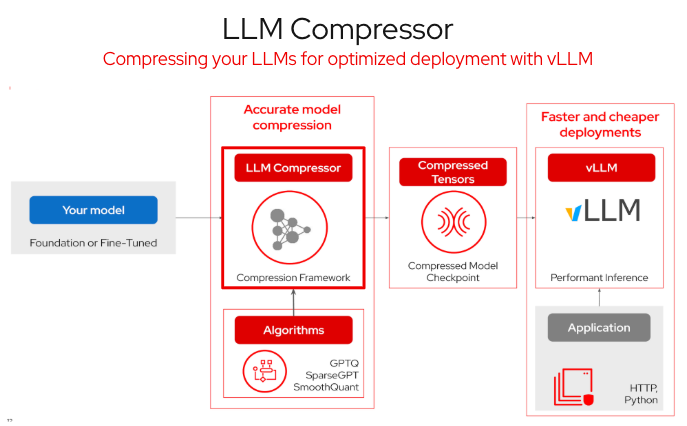

Designed for flexibility, LLM Compressor supports both post-training and training workflows for compression through Modifiers, implementations that apply a specific compression method to a given model. Modifier implementations cover a wide range of compression algorithms and techniques, including:
- **Weight-only quantization (W4A16)** for limited hardware or latency-sensitive applications.
- **Weight and activation quantization (W8A8)** targeting general server scenarios for both integer and floating point formats.
- **2:4 semi-structured sparsity** for further inference acceleration.

### Why optimize models?

There is a growing disparity between model sizes and available GPU memory. Some of today’s largest MoE architectures now exceed 1.8 trillion parameters. In contrast, even advanced GPUs like Blackwell are limited to 192GB of memory. 

Quantization addresses this gap, significantly reducing the memory required to store and run models. For instance, compressing a 109B model from 220GB in BF16 to 55GB using INT4 (Table 1) allows for single-GPU deployment and lowers compute costs. 

For example:  
Llama4 Scout: 109B parameters
|    Optimization    |     Params size (GiB)   |    GPUs                 |
|--------------------|-------------------------|-------------------------|
|      BFloat16      |     109 * 2 ~= 220 GB   |   3 * 80G (3 * H100)    |
|      INT8/FP8      |     109 * 1 ~= 109 GB   |   2 * 80G (2 * H100)    |
|        INT4        |    109 * 0.5 ~= 55 GB   |   1 * 80G (1 * H100)    |

Similarly, quantizing the 400B-parameter Llama Maverick model from 800GB in BF16 to 200GB using INT4 reduces GPU requirements from a 10-GPU multi-node setup to just 3 GPUs.
Llama4 Maverick: 400B parameters
|    Optimization    |     Params size (GiB)   |    GPUs                 |
|--------------------|-------------------------|-------------------------|
|      BFloat16      |     400 * 2 ~= 800 GB   |  10 * 80G (10 * H100)   |
|      INT8/FP8      |     400 * 1 ~= 400 GB   |   5 * 80G (5 * H100)    |
|        INT4        |   400 * 0.5 ~= 200 GB   |   3 * 80G (3 * H100)    |

Optimization provides several advantages. It reduces memory usage, freeing up GPU RAM for critical components like the KV Cache. It accelerates inference by leveraging low-precision tensor cores available in modern GPUs. And most importantly, it achieves minimal or no degradation in model accuracy. In fact, in some cases, the regularization effects of quantization can even improve performance.

### Here's a real exmple of how to estimate the model sizing

**ibm-granite/granite-3.2-8b-instruct model**

Here's the model card - https://huggingface.co/ibm-granite/granite-3.2-8b-instruct \
Here's the model `config.json` - https://huggingface.co/ibm-granite/granite-3.2-8b-instruct/blob/main/config.json
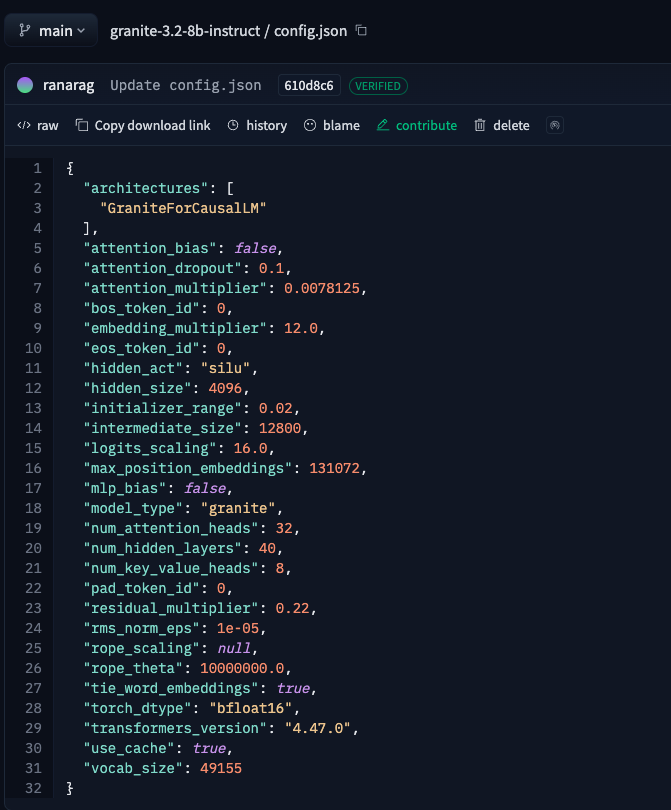

#### Estimation

**Model Card** \
Model size: 8.17B params \
Tensor type: BF16 (2 bytes) \
Number of Hidden Layers: 40 \
Number Key-Value Head: 8 \
Number Attention Head: 32 \
Hidden Size: 4096 (dim per layer) \
Head Size: 128 (Hidden Size / Attention heads) \
Max Context Length: 131072 (Max position embeddings/128K) 

**Model vRAM estimate = Number of Parameters * Model Precision * 20% overhead** \
Model vRAM estimate = 8.17B * BF16(2 bytes) * 1.2 = 18.3 GiB 

**KV Cache estimate = vRAM per token * Context Length * Concurrency** \
vRAM per token = 2 (key & value)  * hidden layers * key-value heads * head size * 2 bytes = 0.16 MiB 

**Concurreny: 1** \
Total KV Cache = 0.16 MiB * 128K * 1 = 20.5 GiB 

**Total vRAM Estimate** = 18.3 + 20.5 = **38.8 GiB**

### Quantization

LLM Compressor supports a wide range of optimization strategies that address different deployment needs. Weight-only schemes like W4A16 are well suited for memory-constrained, low-QPS scenarios. Full quantization using INT8 or FP8 is ideal for high-throughput, compute-intensive deployments. For reducing model size further, 2:4 structured sparsity can be applied. In long-context workloads, quantizing the KV Cache offers additional memory savings.

As Figure 2 illustrates, LLM Compressor sits in the model lifecycle between training and deployment. It takes a Hugging Face-compatible model and applies compression algorithms defined in a modular "recipe." These recipes specify techniques such as round-to-nearest, SmoothQuant, GPTQ, or various sparsity modifiers. 

---
Now, let's try to quantize a model in action.

First, we need install `llmcompressor`.

In [1]:
!pip install llmcompressor==0.5.2 -q


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


---
Make sure llmcompressor library has been installed successfully.

In [2]:
!pip list | grep llmcompressor

llmcompressor                            0.5.2


---
Create a python script - `quantize.py`.

In [3]:
%%writefile quantize.py

from transformers import AutoTokenizer, AutoModelForCausalLM
from llmcompressor.transformers.compression.helpers import calculate_offload_device_map
from llmcompressor import oneshot
from llmcompressor.modifiers.quantization import QuantizationModifier

# First, we load the target model
#model_stub = "mistralai/Mistral-7B-v0.1"
model_stub = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
device_map = calculate_offload_device_map(
        model_stub,
        reserve_for_hessians=False,
        num_gpus=1,
        torch_dtype="auto"
)
model = AutoModelForCausalLM.from_pretrained(
        model_stub,
        device_map=device_map,
        torch_dtype="auto"
)

# Then, we specify the quantization recipe
recipe = QuantizationModifier(
        targets="linear",
        scheme="W4A16",   #NVFP4, W4A16, FP8_dynamic
        ignore=["lm_head"]
)

# Then, we apply quantization
oneshot(model=model, recipe=recipe)

# Finally, we save the quantized model to disk
save_path = model_stub + "-W4A16"
model.save_pretrained(save_path, skip_compression_stats=True, disable_sparse_compression=True)
print(f"Quantized model saved to: {save_path}")

Writing quantize.py


---
**Note:** Concious of the time, we select a very small model `TinyLLama-1.1B-Chat-v1.0` (https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0) to try with quantization. The original Tensor type is `FP16`, we are going to optimize it to `FP8`. 

Run the script above using `python3 quantize.py`

In [4]:
!python3 quantize.py

config.json: 100%|█████████████████████████████| 608/608 [00:00<00:00, 4.25MB/s]
model.safetensors: 100%|████████████████████| 2.20G/2.20G [00:12<00:00, 173MB/s]
generation_config.json: 100%|██████████████████| 124/124 [00:00<00:00, 1.52MB/s]
tokenizer_config.json: 1.29kB [00:00, 9.92MB/s]
tokenizer.model: 100%|████████████████████████| 500k/500k [00:00<00:00, 321MB/s]
tokenizer.json: 1.84MB [00:00, 151MB/s]
special_tokens_map.json: 100%|█████████████████| 551/551 [00:00<00:00, 8.31MB/s]
2025-07-10T02:29:16.490752+0000 | reset | INFO - Compression lifecycle reset
2025-07-10T02:29:16.492408+0000 | from_modifiers | INFO - Creating recipe from modifiers
2025-07-10T02:29:16.519487+0000 | initialize | INFO - Compression lifecycle initialized for 1 modifiers
2025-07-10T02:29:16.519729+0000 | IndependentPipeline | INFO - Inferred `DataFreePipeline` for `QuantizationModifier`
Calibrating weights: 100%|████████████████| 293/293 [00:00<00:00, 309398.56it/s]
2025-07-10T02:29:16.525624+0000 | fina

---
Once the compression is completed, you can see there's a new folder `TinyLlama` been created, which stores the quantized model.

Now, let's take a look at the compressed model.

In [5]:
!ls -lsah TinyLlama/TinyLlama-1.1B-Chat-v1.0-W4A16

total 2.1G
   0 drwxr-sr-x. 2 1001090000 1001090000   99 Jul 10 02:29 .
   0 drwxr-sr-x. 3 1001090000 1001090000   44 Jul 10 02:29 ..
4.0K -rw-r--r--. 1 1001090000 1001090000  675 Jul 10 02:29 config.json
4.0K -rw-r--r--. 1 1001090000 1001090000  124 Jul 10 02:29 generation_config.json
2.1G -rw-r--r--. 1 1001090000 1001090000 2.1G Jul 10 02:29 model.safetensors
4.0K -rw-r--r--. 1 1001090000 1001090000  130 Jul 10 02:29 recipe.yaml


The size of model.safetensors doesn't reduce too much, that's because the original model is very small.  We have tested it against some bigger model such as **Mistral-7B-v0.1** https://huggingface.co/mistralai/Mistral-7B-v0.1, and the reduction / compression rate is significant!

**Pre-quantized, size is ~29.48 GiB**
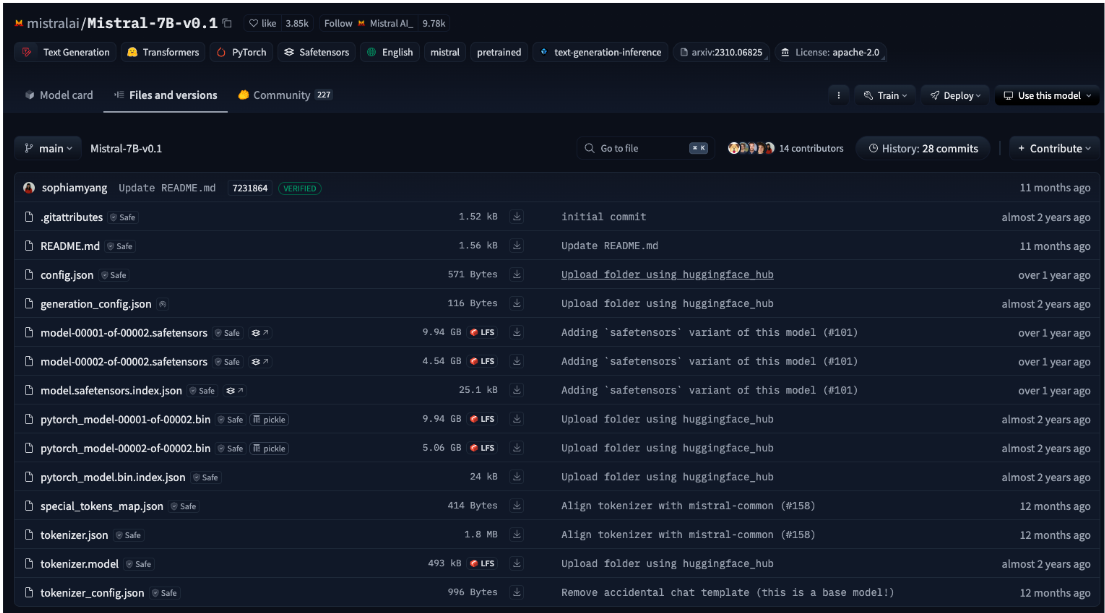

**Post-quantized, size is ~13.7 GiB**
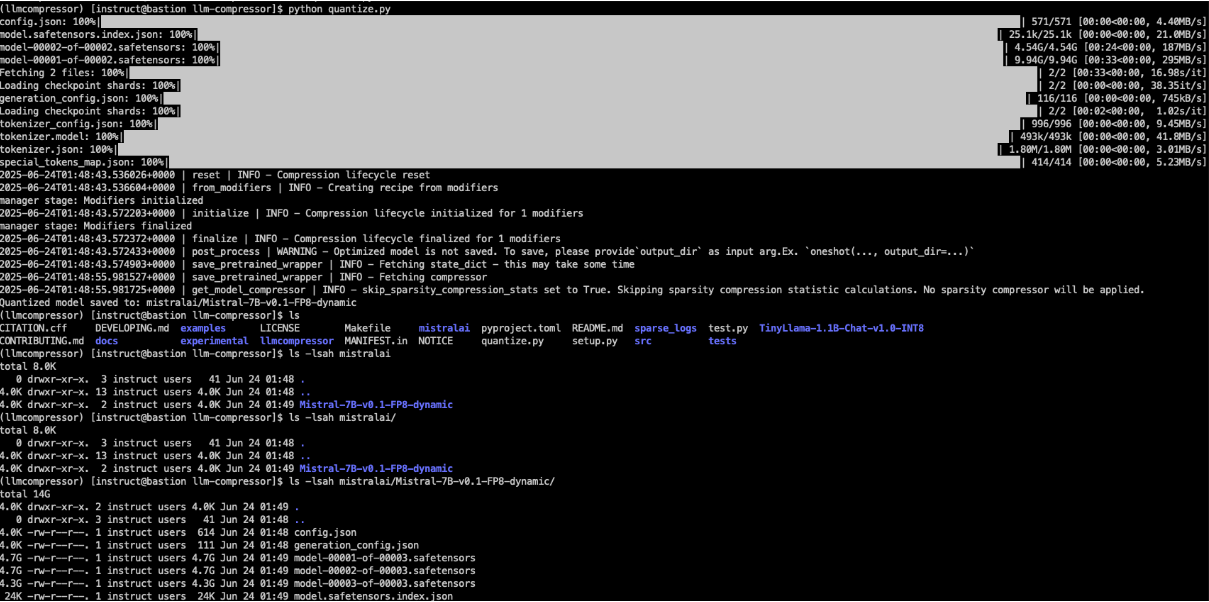

That's **50%+** saving! That also means when you serve the model, it will be more  (+2x) memory efficient.

LLM Compressor supports multiple quantization schemes:
- **W4A16** for memory-bound, low-QPS scenarios.
- **INT8** and **FP8** for compute-bound, high-throughput deployments.
- KV Cache Quantization for efficient long-context inference.
- Structured sparsity (e.g., 2:4) for compact, efficient model representation.

For more info about llmcompressor, you may refer to [LLM Compressor: Optimize LLMs for low-latency deployments](https://developers.redhat.com/articles/2025/05/09/llm-compressor-optimize-llms-low-latency-deployments)

### Validate accuracy

Quantization helps to optimize a model's memory efficiency, but what about the accuracy? In this section, we will look at the recovery rate by comparing the post-quantized model with pre-quantized model we tested in last section.

We will be using `lm-eval` script in vLLM.

In [7]:
!pip install vllm==0.9.1 lm-eval==0.4.7 -q


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


---
First, we evaluate the unquantized model `TinyLlama/TinyLlama-1.1B-Chat-v1.0` on hellaswag task.

**Note: This process can take quite long time (up to 30 mins) to run...**

In [8]:
!lm-eval --model vllm --model_args pretrained=TinyLlama/TinyLlama-1.1B-Chat-v1.0,tensor_parallel_size=1 \
--limit 250 --tasks hellaswag --num_fewshot 5 --batch_size 5

INFO 07-10 02:31:34 [__init__.py:244] Automatically detected platform cuda.
2025-07-10:02:31:36,851 INFO     [__main__.py:279] Verbosity set to INFO
2025-07-10:02:31:43,262 WARNING  [__main__.py:312]  --limit SHOULD ONLY BE USED FOR TESTING.REAL METRICS SHOULD NOT BE COMPUTED USING LIMIT.
2025-07-10:02:31:43,263 INFO     [__main__.py:376] Selected Tasks: ['hellaswag']
2025-07-10:02:31:43,266 INFO     [evaluator.py:164] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-07-10:02:31:43,266 INFO     [evaluator.py:201] Initializing vllm model, with arguments: {'pretrained': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0', 'tensor_parallel_size': 1}
INFO 07-10 02:31:53 [config.py:823] This model supports multiple tasks: {'embed', 'generate', 'reward', 'classify', 'score'}. Defaulting to 'generate'.
INFO 07-10 02:31:53 [config.py:2195] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 07-10 02:31:55 [core.

---
We save that result as **Pre-quantized-eval**. \
**Note: You may see different value in your run.**

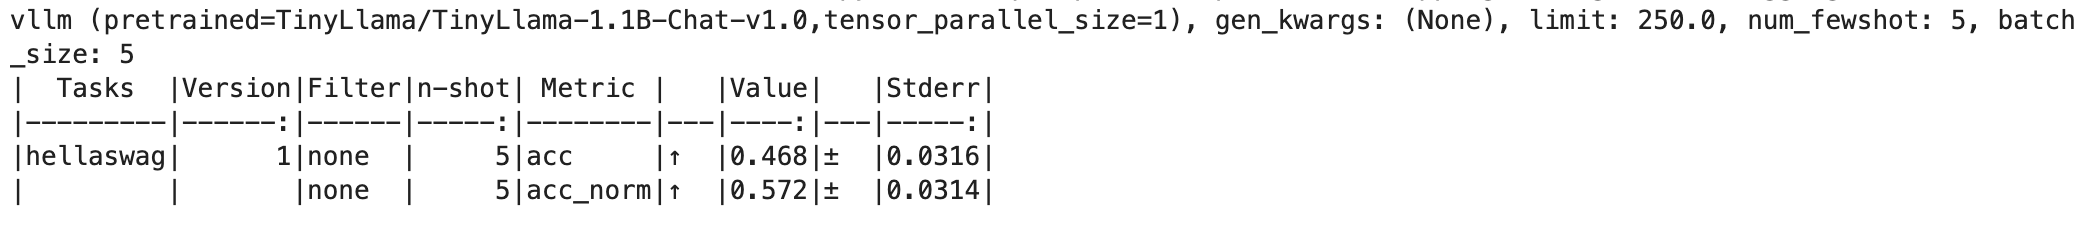

Now we run the same command against the post-quantized model. \
**Note:** You will need specify the Tokenizer explicitly.

In [17]:
!lm-eval --model vllm --model_args pretrained=TinyLlama/TinyLlama-1.1B-Chat-v1.0-W4A16,tokenizer=TinyLlama/TinyLlama-1.1B-Chat-v1.0,tensor_parallel_size=1 \
--limit 250 --tasks hellaswag --num_fewshot 5 --batch_size 5

INFO 07-04 04:11:50 [__init__.py:243] Automatically detected platform cuda.
2025-07-04:04:11:52,951 INFO     [__main__.py:279] Verbosity set to INFO
2025-07-04:04:11:59,488 WARNING  [__main__.py:312]  --limit SHOULD ONLY BE USED FOR TESTING.REAL METRICS SHOULD NOT BE COMPUTED USING LIMIT.
2025-07-04:04:11:59,488 INFO     [__main__.py:376] Selected Tasks: ['hellaswag']
2025-07-04:04:11:59,490 INFO     [evaluator.py:164] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-07-04:04:11:59,491 INFO     [evaluator.py:201] Initializing vllm model, with arguments: {'pretrained': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0-W4A16', 'tokenizer': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0', 'tensor_parallel_size': 1}
INFO 07-04 04:11:59 [__init__.py:31] Available plugins for group vllm.general_plugins:
INFO 07-04 04:11:59 [__init__.py:33] - lora_filesystem_resolver -> vllm.plugins.lora_resolvers.filesystem_resolver:register_filesyst

---
We save the result as **post-quantized-eval**.
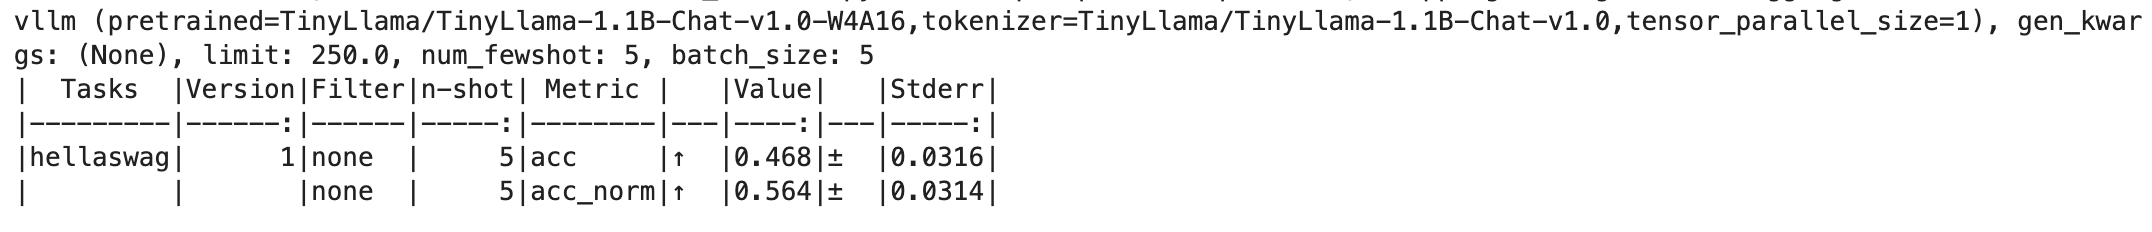

By comparsing the pre-quantized-eval and post-quantized-eval,
- The value reduces from **0.572** to **0.564**

#### Accuracy Recovery

Accuracy Recovery = Post-quantized-accuracy / Pre-quantized-accuracy.

So, the recovery here is 0.564 / 0.572 * 100% = **98.6%**

Acutally, Red Hat AI runs more than 500,000 evaluations on quantized models, which retains about 99% accuracy.

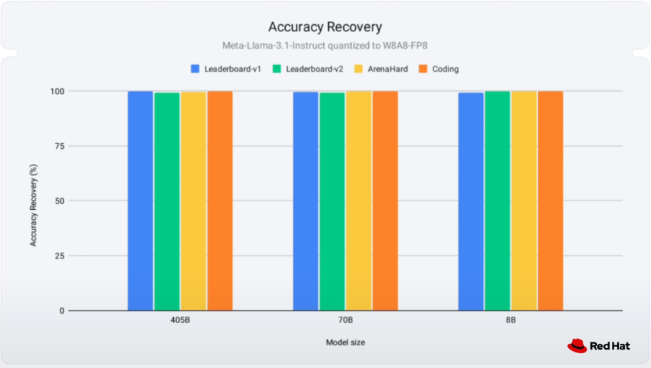

### Summary

LLMs promise a competitive edge, especially if you can tame their costs and complexity. Optimization and vLLM help make that possible, turning potential into profits and operational efficiencies. Expect lower operational costs (think 40-50% GPU savings), faster time-to-market with streamlined deployment and happier customers thanks to real-time responsiveness. Whether you’re scaling a startup or steering an enterprise, this combo lets you deploy AI smarter and cheaper!

The proof is in the results. A popular gaming company used Red Hat’s INT8 quantized Llama 70B with vLLM to power hundreds of thousands of daily code generations, hitting 10 queries per second at 50ms per token. By halving GPU usage, they slashed infrastructure costs by 50% without sacrificing performance. 

---
This is the end of Lab 2 - Optimize the models.